# Contrail metrics for specific routes

The purpose of the notebook is to quantify contrail metrics along specific flight trajectories, enabling differentiated assessments of aircraft operations.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from geographiclib.geodesic import Geodesic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

from aerometrics.paper.functions.metric_functions import gwp_rf_contrails, gwp_erf_contrails, egwp_contrails, ratr_contrails
from aerometrics.paper.functions.route_functions import great_circle_path, mean_along_path

## Metric choice and contrails settings

In [2]:
metric = "r-ATR"    
time_horizon = 100
scaling_coefficient_sensitivity = 1 # 3.095
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

if metric == "GWP_RF": 
    metric_function = gwp_rf_contrails
    metric_label = rf"$GWP_{{\mathrm{{RF}}, {time_horizon}}}$"
elif metric == "GWP_ERF": 
    metric_function = gwp_erf_contrails
    metric_label = rf"$GWP_{{\mathrm{{ERF}}, {time_horizon}}}$"
elif metric == "EGWP": 
    metric_function = egwp_contrails
    metric_label = rf"$EGWP_{{{time_horizon}}}$"
elif metric == "r-ATR": 
    metric_function = ratr_contrails
    metric_label = rf"$r\text{{-}}ATR_{{{time_horizon}}}$"

## Aircraft and route

In [3]:
emission_index = 70
nb_pax = 300

# Exemple : Paris (48.8566, 2.3522) -> New York (40.7128, -74.0060)
lat_paris, lon_paris = 48.8566, 2.3522 # Paris
lat_newyork, lon_newyork = 40.7128, -74.0060 # New York
lat_singapour, lon_singapour = 1.3521, 103.8198 # Singapour
lat_noumea, lon_noumea = -22.2711, 166.4410 # Nouméa
lat_tokyo, lon_tokyo = 35.6895, 139.6917 # Tokyo
lat_bogota, lon_bogota = 4.7110, -74.0721  # Bogota
lat_addis_abeba, lon_addis_abeba = 9.0320, 38.7469  # Addis-Abeba
lat_bangkok, lon_bangkok = 13.7563, 100.5018  # Bangkok
lat_los_angeles, lon_los_angeles = 34.0522, -118.2437  # Los Angeles
lat_lisbonne, lon_lisbonne = 38.7742, -9.1342   # Lisbonne (Aéroport Humberto Delgado - LIS)
lat_acores, lon_acores = 37.7412, -25.6979      # Açores (Aéroport João Paulo II - Ponta Delgada - PDL)
lat_toulouse, lon_toulouse = 43.6293, 1.3641   # Toulouse (Aéroport Toulouse-Blagnac - TLS)
lat_tahiti, lon_tahiti = -17.5537, -149.6063   # Tahiti (Aéroport International de Tahiti-Faa'a - PPT)

lat1, lon1 = lat_paris, lon_paris
lat2, lon2 = lat_noumea, lon_noumea
waypoint = (lat_singapour, lon_singapour)

lat1, lon1 = lat_toulouse, lon_toulouse
lat2, lon2 = lat_acores, lon_acores
waypoint = (lat_lisbonne, lon_lisbonne)

lat1, lon1 = lat_paris, lon_paris
lat2, lon2 = lat_tahiti, lon_tahiti
waypoint = (lat_los_angeles, lon_los_angeles)

lat1, lon1 = lat_paris, lon_paris
lat2, lon2 = lat_noumea, lon_noumea
waypoint = (lat_singapour, lon_singapour)

## Application

Flight distance: 18007.623831324086 km
CO2 emissions: 1260.533668192686 kgCO2/PAX (for 70 gCO2/RPK)
Contrails equivalent emissions: 357.30051973746833 kgCO2-eq/PAX (for 300 passengers per aircraft)
Total equivalent emissions: 1617.8341879301543 kgCO2-eq/PAX


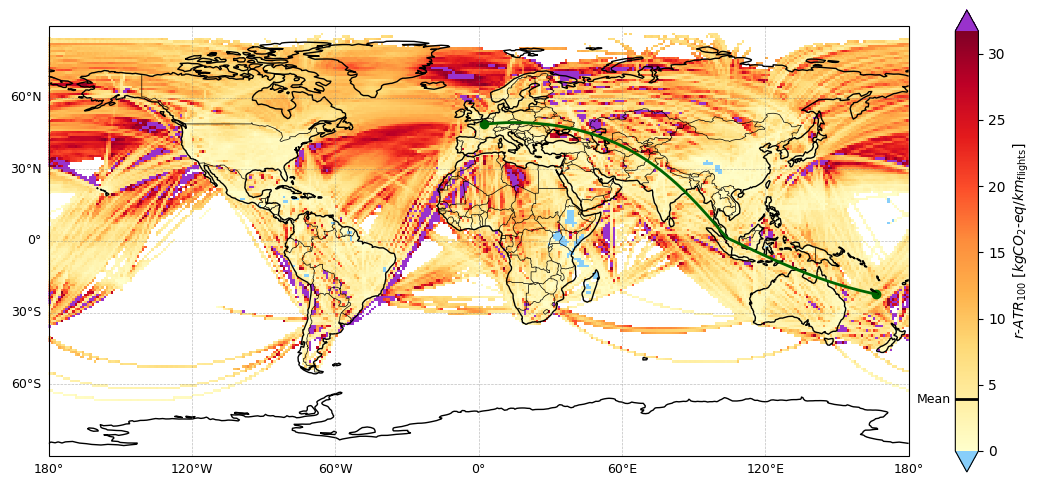

In [4]:
# Calculations

file_path = 'data/contrails_data.nc'
ds = xr.open_dataset(file_path)
ds['Metric'] = metric_function(time_horizon, ds['RF_flight_distance_normalised'] * scaling_coefficient_sensitivity, ratio_erf_rf_contrails, efficacy_erf_contrails)
metric_i = ds['Metric'] * ds['seg_length_km'].where(np.isfinite(ds['seg_length_km']), np.nan) / ds['seg_length_km'].sum(dim=['lat', 'lon']).item()
mean_metric = metric_i.sum().item()

lats, lons, total_dist_km = great_circle_path(lat1, lon1, lat2, lon2, waypoint=waypoint)
print("Flight distance:", total_dist_km, "km")
co2_emissions = total_dist_km * emission_index/1000
print("CO2 emissions:", float(co2_emissions), "kgCO2/PAX (for", emission_index, "gCO2/RPK)")
mean, values = mean_along_path(ds['Metric'], lats, lons)
contrails_emissions = mean * total_dist_km / nb_pax # kgCO2-eq
print("Contrails equivalent emissions:", float(contrails_emissions), "kgCO2-eq/PAX (for", nb_pax, "passengers per aircraft)")
print("Total equivalent emissions:", float(co2_emissions+contrails_emissions), "kgCO2-eq/PAX")


# Plot data
minimal_traffic_per_cell = 1e4
data_masked = ds['Metric'].where(ds['seg_length_km'] >= minimal_traffic_per_cell)
data_np = data_masked.values


# Plot settings

## Bounds and norm
vmin = 0
vmax = data_masked.quantile(0.97)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

## Colormap
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))
cmap.set_under('lightskyblue')
cmap.set_over('darkorchid')


# Plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

data_plot = ax.pcolormesh(ds['Metric']['lon'], ds['Metric']['lat'], data_np,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = plt.colorbar(data_plot, ax=ax, extend='both', fraction=0.025)
cbar.ax.axhline(mean_metric, color='black', linewidth=2)
cbar.ax.text(-0.2, mean_metric, 'Mean', va='center', ha='right', color='black', fontsize=9, transform=cbar.ax.get_yaxis_transform())
cbar.set_label(metric_label+ r" [$kgCO_2\text{-}eq/km_{\text{flights}}$]", fontsize=10)

ax.plot(lons, lats, color='darkgreen', linestyle="-", transform=ccrs.Geodetic(), linewidth=2)
ax.scatter(lon1, lat1, color='darkgreen')
ax.scatter(lon2, lat2, color='darkgreen')

plt.show()